# Recession Probability Calculator with plots
## Using Treasury Spreads, SPX and VIX

The goal of this notebook is to test if treasury spreads 10Y-2Y, 10Y-3M along with SPX and VIX are successful in indicating impending economic recession. 
This concept is based on paper:
https://www.frbsf.org/economic-research/publications/economic-letter/2018/march/economic-forecasts-with-yield-curve/


In [8]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from pylab import rcParams
import matplotlib.dates as mdates
import matplotlib.ticker as plticker

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import classification_report

import os
#os.getcwd()

%matplotlib inline
rcParams['figure.figsize']=15,12
sb.set_style('whitegrid')

# Load Data Sets

## Load recession indicator data

The data sources are as below:
ecession Data:

https://fred.stlouisfed.org/series/USREC

Treasury 10Y-2Y

https://fred.stlouisfed.org/series/T10Y2Y

Treasury 10Y-3M

https://fred.stlouisfed.org/series/T10Y3M

SP500

https://finance.yahoo.com/quote/%5EGSPC/history?period1=-1325635200&period2=1609545600&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true

VIX

https://finance.yahoo.com/quote/%5EVIX/history?period1=631238400&period2=1609545600&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true

In [9]:
dfRec = pd.read_csv("./USREC_Dec2020.csv")
dfRec.head() #note data is monthly
print(dfRec.dtypes) #Check Data Type of columns
dfRec['DT'] = pd.to_datetime(dfRec['DATE'], format='%Y-%m-%d') #convert date from string to datetime
print("\n DATE obj--->DT datetime \n")
print(dfRec.dtypes) #Recheck
dfRec = dfRec.drop('DATE',axis=1) #drop the original DATE column
dfRec=dfRec.set_index('DT')#set index to new datetime dt

start_date = dfRec.index.min() - pd.DateOffset(day=1)
end_date = dfRec.index.max() + pd.DateOffset(day=31)
dates = pd.date_range(start_date, end_date, freq='D') #create dates between a date range
dates.name = 'date'
dfRec = dfRec.reindex(dates, method='ffill') #reindex to new dates and forward fill. 
dfRec.tail(5)


DATE     object
USREC     int64
dtype: object

 DATE obj--->DT datetime 

DATE             object
USREC             int64
DT       datetime64[ns]
dtype: object


,USREC
date,
2020-12-27,1
2020-12-28,1
2020-12-29,1
2020-12-30,1
2020-12-31,1


## Load Treasury, SPX, VIX data

In [10]:

def extractStLouisData(Name):
    header = Name.split('.')[0]
    df10y2y=pd.read_csv(Name)

    df10y2y['DT'] = pd.to_datetime(df10y2y['DATE'], format='%Y-%m-%d')
    df10y2y = df10y2y.drop('DATE',axis=1)
    df10y2y = df10y2y.set_index('DT')
    df10y2y[header] = pd.to_numeric(df10y2y[header],errors='coerce')
    if df10y2y[header].isnull().values.any(): #check if there are any nan values
    #df10y2y['T10Y2Y'].index[df10y2y['T10Y2Y'].apply(np.isnan)] check index where nan. 
        df10y2y = df10y2y.dropna(subset=[header])
    display(df10y2y.head())
    return df10y2y

def extractYahooData(Name):
    header = Name.split('.')[0]
    dfx = pd.read_csv(Name)
    dfx['DT'] = pd.to_datetime(dfx['Date'], format='%Y-%m-%d')
    dfx = dfx.drop(['Date','Open','High','Low','Close','Volume'],axis=1)
    dfx = dfx.set_index('DT')
    dfx['Adj Close'].isnull().values.any()
    dfx=dfx.rename(columns={'Adj Close':header})
    display(dfx.tail())
    return dfx    

#10Y-2Y
df10y2y = extractStLouisData('T10Y2Y.csv')
#10Y-3M
df10y3m=extractStLouisData('T10Y3M.csv')
#SPX
dfspx = extractYahooData('SP500.csv')
#VIX
dfvix = extractYahooData('VIX.csv')



,T10Y2Y
DT,
1976-06-01,0.68
1976-06-02,0.71
1976-06-03,0.70
1976-06-04,0.77
1976-06-07,0.79


,T10Y3M
DT,
1982-01-04,2.32
1982-01-05,2.24
1982-01-06,2.43
1982-01-07,2.46
1982-01-08,2.50


,SP500
DT,
2020-12-24,3703.060059
2020-12-28,3735.360107
2020-12-29,3727.040039
2020-12-30,3732.040039
2020-12-31,3756.070068


,VIX
DT,
2020-12-24,21.530001
2020-12-28,21.700001
2020-12-29,23.080000
2020-12-30,22.770000
2020-12-31,22.750000


# Merge DataFrames on Index

In [11]:
#df = dfRec.merge(df10y2y,left_index=True,right_index=True)
df = pd.concat([dfRec,df10y2y,df10y3m,dfspx,dfvix],axis=1,join='inner')

In [12]:
df.tail()

,USREC,T10Y2Y,T10Y3M,SP500,VIX
2020-12-24,1,0.81,0.85,3703.060059,21.530001
2020-12-28,1,0.81,0.83,3735.360107,21.700001
2020-12-29,1,0.82,0.84,3727.040039,23.080000
2020-12-30,1,0.81,0.85,3732.040039,22.770000
2020-12-31,1,0.80,0.84,3756.070068,22.750000


In [13]:
df.isnull().values.any()

False

## Standardize the input variable data

In [14]:
Xdf = df[['T10Y2Y','T10Y3M','SP500','VIX']]
Ydf =df[['USREC']]
scaler = StandardScaler()
XdfStd = pd.DataFrame(scaler.fit_transform(Xdf),columns=Xdf.columns,index=Xdf.index)
XdfStd.head()

,T10Y2Y,T10Y3M,SP500,VIX
1990-01-02,-1.224741,-1.389850,-1.298425,-0.274439
1990-01-03,-1.247556,-1.398627,-1.299669,-0.157128
1990-01-04,-1.236148,-1.363517,-1.303801,-0.029938
1990-01-05,-1.201926,-1.310852,-1.308441,0.079964
1990-01-08,-1.167704,-1.284519,-1.306315,0.098487


# Explore Data

In [15]:
df['USREC'].value_counts()

0    6832
1     914
Name: USREC, dtype: int64

In [16]:
XdfStd.describe()

,T10Y2Y,T10Y3M,SP500,VIX
count,7.746000e+03,7.746000e+03,7.746000e+03,7.746000e+03
mean,1.245167e-16,9.349322e-17,-2.052006e-15,2.984459e-16
std,1.000065e+00,1.000065e+00,1.000065e+00,1.000065e+00
min,-1.897774e+00,-2.320272e+00,-1.384314e+00,-1.274672e+00
25%,-9.367058e-01,-8.368629e-01,-6.576945e-01,-7.177524e-01
50%,-7.259992e-02,-2.054898e-02,-1.596501e-01,-2.460379e-01
75%,8.742092e-01,8.308752e-01,3.099654e-01,4.204754e-01
max,2.014943e+00,1.910516e+00,3.243223e+00,7.807687e+00


In [17]:
XdfStd.corr()

,T10Y2Y,T10Y3M,SP500,VIX
T10Y2Y,1.000000,0.925227,-0.222416,0.094008
T10Y3M,0.925227,1.000000,-0.361607,0.042682
SP500,-0.222416,-0.361607,1.000000,-0.077989
VIX,0.094008,0.042682,-0.077989,1.000000


<AxesSubplot:xlabel='USREC', ylabel='count'>

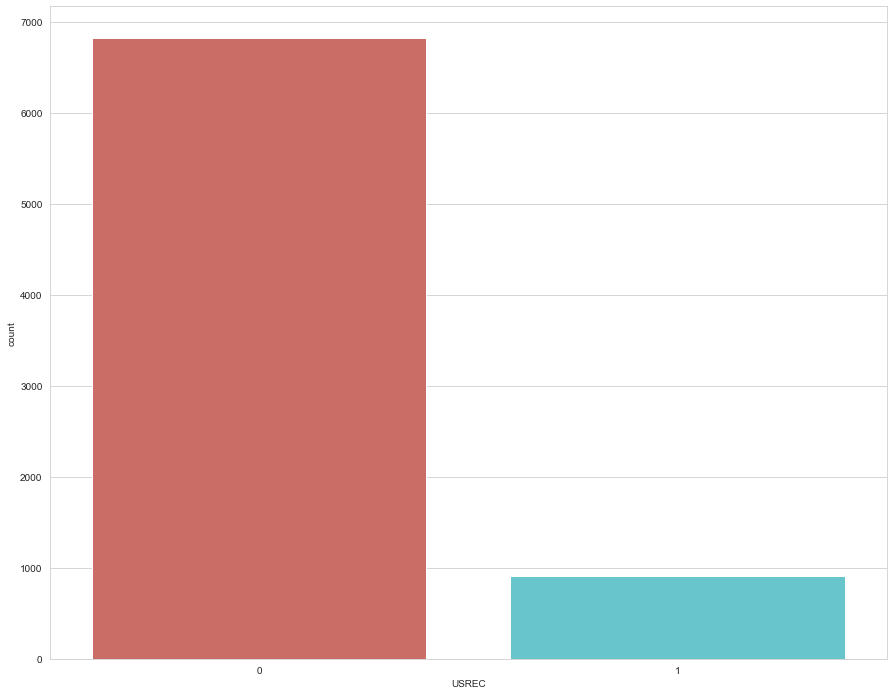

In [18]:
sb.countplot(x='USREC',data=df,palette='hls')

## Percentage of days in recession

In [19]:
df['USREC'].value_counts()/len(df) 

0    0.882004
1    0.117996
Name: USREC, dtype: float64

In [20]:
df['recBoundaries'] = df['USREC'].diff()

In [21]:
recessionBegin= df[df['recBoundaries']==1].index.tolist() #Dates when recession begins
recessionEnd = df[df['recBoundaries']==-1].index.tolist() #Dates when recession ends
#If all recessions are in the past then start and end date vectors will be of same length
#Unless there is a current recession in progress and the end date is in future. 

if(len(recessionBegin)>len(recessionEnd)): #if recession is still in progress append last available date to recessionEnd
    t = df.iloc[[-1]].index.tolist()[0]
    recessionEnd.append(t)
recessionStartEndDates = zip(recessionBegin,recessionEnd)
x=list(recessionStartEndDates)
recessionBounds = np.array(x)

[Timestamp('1990-08-01 00:00:00') Timestamp('1991-04-01 00:00:00')]
[Timestamp('2001-04-02 00:00:00') Timestamp('2001-12-03 00:00:00')]
[Timestamp('2008-01-02 00:00:00') Timestamp('2009-07-01 00:00:00')]
[Timestamp('2020-03-02 00:00:00') Timestamp('2020-12-31 00:00:00')]


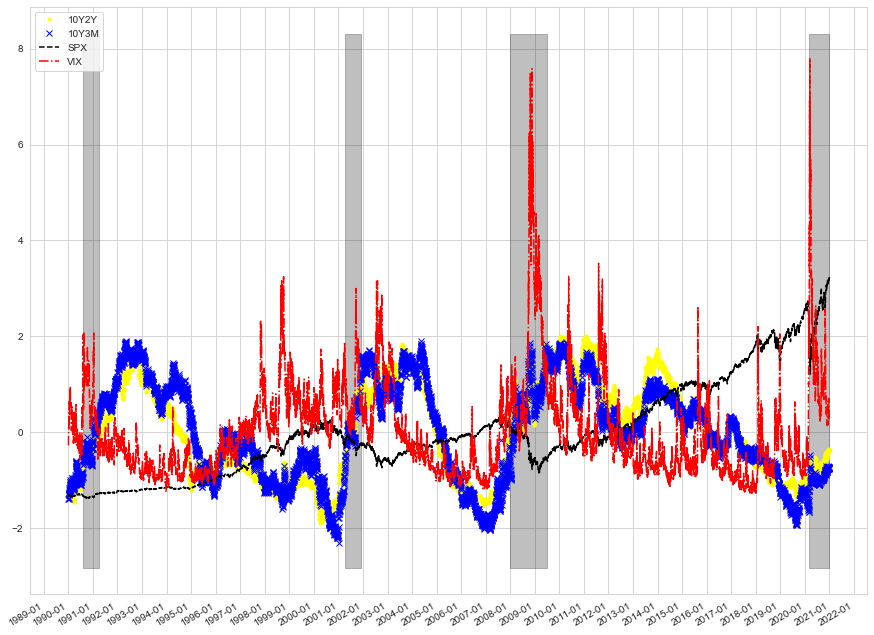

In [22]:
#rcParams['figure.figsize']=18,16
fig,ax = plt.subplots()
dates = df.index
#print(dates[-1])
ax.plot_date(dates,XdfStd['T10Y2Y'],'.',scaley=True,color='yellow',label='10Y2Y')
ax.plot_date(dates,XdfStd['T10Y3M'],'x',scaley=True,color='blue',label='10Y3M')
ax.plot_date(dates,XdfStd['SP500'],'--',scaley=True,color='black',label='SPX')
ax.plot_date(dates,XdfStd['VIX'],'-.',scaley=True,color='red',label='VIX')

ax.xaxis.set_major_locator(mdates.YearLocator())
#ax.xaxis.set_minor_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
#ax.set_xlim(df.iloc[[0]].index.tolist()[0],df.iloc[[-1]].index.tolist()[0])

y1,y2 = ax.get_ylim()
for row in recessionBounds:
    print(row)
    ax.fill_between(row,y1,y2,alpha=0.25,color='k')
ax.legend()
fig.autofmt_xdate()
plt.show()

# Modeling Strategy

* Based on the graph above, we observe that 10Y2Y and 10Y3M spreads attain their local minima a few months prior to the recession, so for now we manually chose the lag to be 6m (180days) on all feature variables, later we will use a grid search to find the optimized lag. It also makes modelings sense to introduce lags in x-variables as we want some future prediction capability in our model. i.e if we have today's data we should be able to predict probability of recession 6months ahead. 

* We will create test and train test based on stratification on the recession indicator variable - because out of all the data we are in recession only 12% of time. Thus the training split should indicate the same split. 

* Use Logistic Regression - only on training data

* Our regression equation will be of form y(t) = a*[X(t-6M)] +[C]

* Evaluate Regression on test data



In [23]:
XdfStdLagged = XdfStd.shift(periods=180,freq='D') 
#Since freq='D' is specified the index will be shifted and no NaN values created
XdfStdLagged.head()
XYdf = pd.concat([Ydf,XdfStdLagged],axis=1,join='inner')
display(XYdf.head())
display(XYdf.tail())
#confirm the shift
print(XdfStd.loc['1990-01-03'])
print("\n After Lag:\n")
print(XYdf.loc['1990-07-02'])

XYdf.isnull().values.any() #Check if there are any null values in the data set. 

,USREC,T10Y2Y,T10Y3M,SP500,VIX
1990-07-02,0,-1.247556,-1.398627,-1.299669,-0.157128
1990-07-03,0,-1.236148,-1.363517,-1.303801,-0.029938
1990-07-09,0,-1.167704,-1.240631,-1.314980,0.367685
1990-07-10,0,-1.156297,-1.275741,-1.313348,0.072555
1990-07-11,0,-1.110668,-1.170410,-1.324848,0.639353


,USREC,T10Y2Y,T10Y3M,SP500,VIX
2020-12-21,1,-0.734226,-1.012414,2.299506,1.775420
2020-12-22,1,-0.722818,-1.029969,2.344208,1.575374
2020-12-23,1,-0.768448,-1.047525,2.244306,1.885322
2020-12-28,1,-0.711411,-1.003637,2.387132,1.130826
2020-12-29,1,-0.711411,-1.012414,2.406054,1.014749


T10Y2Y   -1.247556
T10Y3M   -1.398627
SP500    -1.299669
VIX      -0.157128
Name: 1990-01-03 00:00:00, dtype: float64

 After Lag:

USREC     0.000000
T10Y2Y   -1.247556
T10Y3M   -1.398627
SP500    -1.299669
VIX      -0.157128
Name: 1990-07-02 00:00:00, dtype: float64


False

In [24]:
XYdf["USREC"].value_counts()/len(XYdf) #Check recession days split again

0    0.879556
1    0.120444
Name: USREC, dtype: float64

In [25]:

split = StratifiedShuffleSplit(n_splits=1, test_size=0.3,random_state=42)
for train_indx,test_indx in split.split(XYdf,XYdf['USREC']):
    strat_train_set = XYdf.iloc[train_indx]
    strat_test_set = XYdf.iloc[test_indx]
    

In [26]:
strat_train_set['USREC'].value_counts()/len(strat_train_set) #Check recession days split in training data

0    0.879651
1    0.120349
Name: USREC, dtype: float64

In [27]:
strat_test_set['USREC'].value_counts()/len(strat_test_set)

0    0.879336
1    0.120664
Name: USREC, dtype: float64

In [28]:
LR = LogisticRegression(class_weight='balanced')
Xtrain = strat_train_set.loc[:,strat_train_set.columns!='USREC'].values
Ytrain = strat_train_set.loc[:,strat_train_set.columns=='USREC'].values.ravel()

Xtest = strat_test_set.loc[:,strat_test_set.columns!='USREC'].values
Ytest = strat_test_set.loc[:,strat_test_set.columns=='USREC'].values.ravel()

LR.fit(Xtrain,Ytrain)
Ypred = LR.predict(Xtest)
print("Accuracy of classifier on test set:{:.2f}\n\n".format(LR.score(Xtest,Ytest)))
print(classification_report(Ytest,Ypred))

Accuracy of classifier on test set:0.74


              precision    recall  f1-score   support

           0       0.95      0.74      0.84      1166
           1       0.28      0.74      0.41       160

    accuracy                           0.74      1326
   macro avg       0.62      0.74      0.62      1326
weighted avg       0.87      0.74      0.78      1326



# Plot the porbability of recession
The probability prediction dates are to be indexed to the lagged standardized X (feature/independent) variables
This also allows us to predict probability 6months in future, as our model uses 6 months lagged data.
We also conduct EWMA smoothing over the probability with com = 9.5, resulting in alpha=0.1, 1-alpha = 0.90.
alpha=1/(1+com)
weighted_average[i] = (1-alpha)*weighted_average[i-1] + alpha*arg[i]

However, to plot the SPX data on same plot we make sure to use the correct date indices of the realized data. 


In [29]:
XlaggedFullArray = XdfStdLagged.values
recessionProbability = LR.predict_proba(XlaggedFullArray)[:,1]
probDf = pd.DataFrame(recessionProbability,columns=['RecProb'],index=XdfStdLagged.index)
probDf['ewma'] = probDf['RecProb'].ewm(com=9.5).mean() #20-day EWMA, 
probDf.tail()


,RecProb,ewma
2021-06-22,0.777606,0.804783
2021-06-26,0.788187,0.803202
2021-06-27,0.816863,0.804503
2021-06-28,0.807105,0.804751
2021-06-29,0.808870,0.805143


[Timestamp('1990-08-01 00:00:00') Timestamp('1991-04-01 00:00:00')]
[Timestamp('2001-04-02 00:00:00') Timestamp('2001-12-03 00:00:00')]
[Timestamp('2008-01-02 00:00:00') Timestamp('2009-07-01 00:00:00')]
[Timestamp('2020-03-02 00:00:00') Timestamp('2020-12-31 00:00:00')]


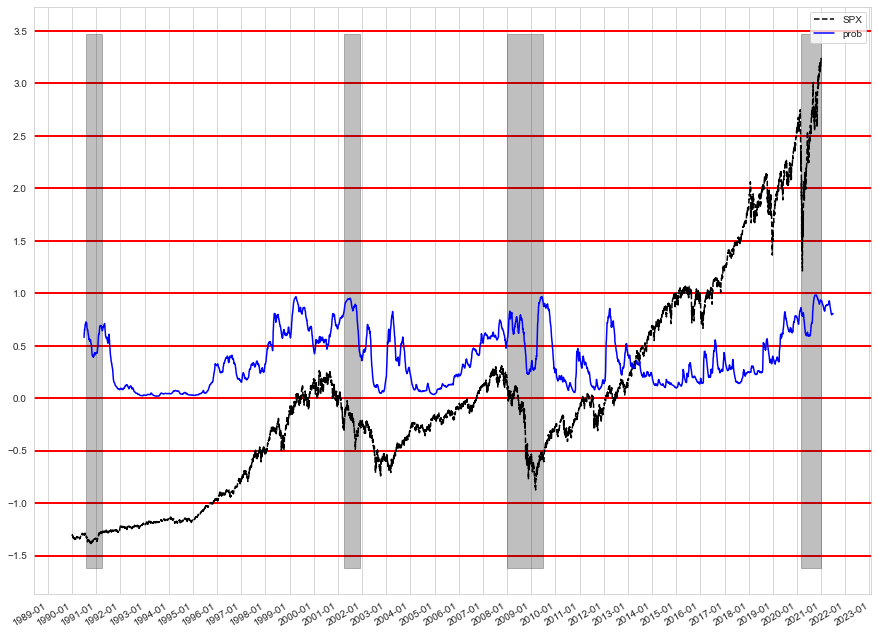

In [30]:
fig,ax = plt.subplots()
dates = probDf.index
#ax.plot_date(XdfStd.index,XdfStd['T10Y2Y'],'.',scaley=True,color='yellow',label='10Y2Y')
#ax.plot_date(dates,XdfStd['T10Y3M'],'x',scaley=True,color='blue',label='10Y3M')
ax.plot_date(XdfStd.index,XdfStd['SP500'],'--',scaley=True,color='black',label='SPX')
#ax.plot_date(dates,XdfStd['VIX'],'-.',scaley=True,color='red',label='VIX')
ax.plot_date(dates,probDf['ewma'],'-',scaley=True,color='blue',label='prob')

ax.xaxis.set_major_locator(mdates.YearLocator())
#ax.xaxis.set_minor_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
#ax.set_xlim(df.iloc[[0]].index.tolist()[0],df.iloc[[-1]].index.tolist()[0])
majorloc=plticker.MultipleLocator(base=0.5)
ax.yaxis.set_major_locator(majorloc)
minorloc=plticker.MultipleLocator(base=0.1)
ax.yaxis.set_minor_locator(minorloc)

y1,y2 = ax.get_ylim()
for row in recessionBounds:
    print(row)
    ax.fill_between(row,y1,y2,alpha=0.25,color='k')
ax.legend()
fig.autofmt_xdate()
ax.grid(b=True,which='major',axis='y',color='r',linewidth=2)
plt.show()

0.7405338765008577


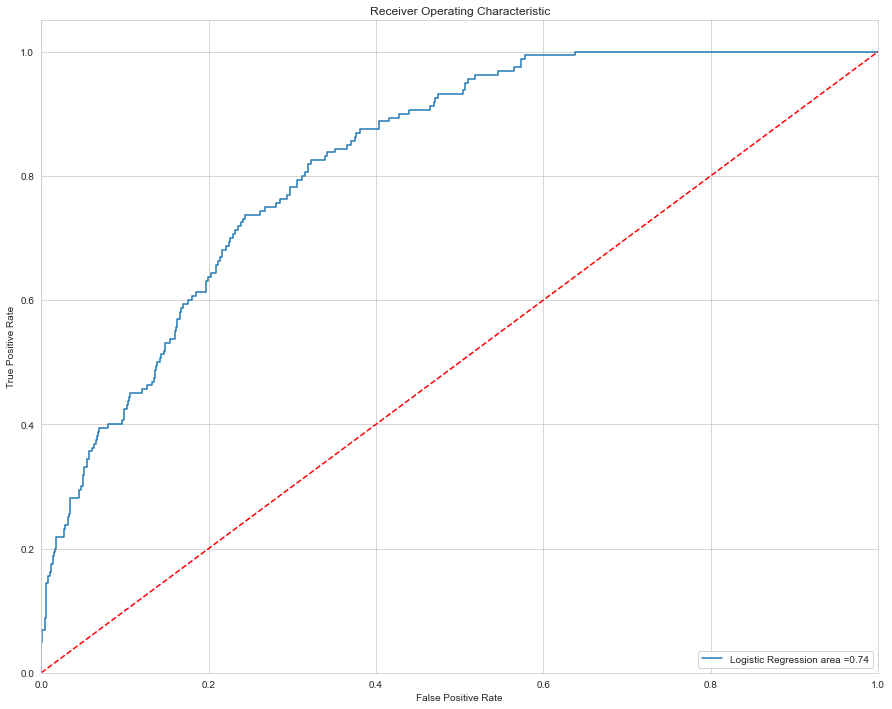

In [31]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

roc_auc = roc_auc_score(Ytest,LR.predict(Xtest))
print(roc_auc)
fpr,tpr,thresholds = roc_curve(Ytest,LR.predict_proba(Xtest)[:,1])
plt.figure()
plt.plot(fpr,tpr,label='Logistic Regression area ={:.2f}'.format(roc_auc))
plt.plot([0,1],[0,1],'r--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()